## Preprocessing

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
labels = pd.read_csv('data/rsna-pneumonia-detection-challenge/rsna_heart_detection.csv')
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [3]:
ROOT_PATH = Path('data/rsna-pneumonia-detection-challenge/stage_2_train_images')
SAVE_PATH = Path('processed/heart-detection')

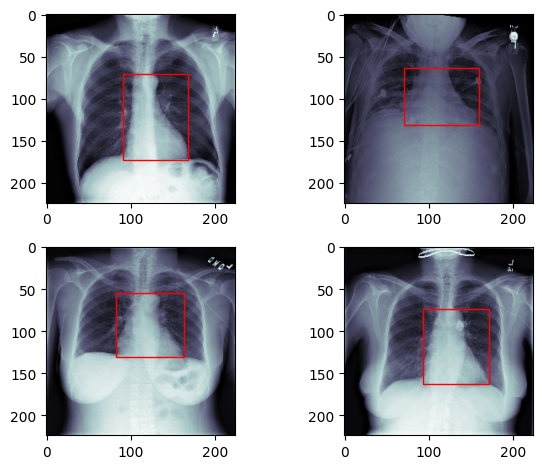

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=2)
c = 0

for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data['name']
        dcm_path = ROOT_PATH / str(patient_id)
        dcm_path = dcm_path.with_suffix('.dcm')

        dcm = pydicom.read_file(dcm_path)
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))

        x = data['x0']
        y = data['y0']
        width = data['w']
        height = data['h']

        axes[i][j].imshow(dcm_array, cmap='bone')
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axes[i][j].add_patch(rect)
        c += 1

fig.tight_layout()

In [5]:
sums, sums_squared = 0, 0
normalizer = 224 * 224
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels['name'])):
    dcm_path = ROOT_PATH / str(patient_id)
    dcm_path = dcm_path.with_suffix('.dcm')

    dcm = pydicom.read_file(dcm_path)
    dcm_array = dcm.pixel_array
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)

    train_or_val = 'train' if counter < 400 else 'val'

    if train_or_val == 'train':
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)

    current_save_path = SAVE_PATH / train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path / patient_id, dcm_array)

    if train_or_val == 'train':
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

In [6]:
np.save('processed/heart-detection/train_subjects', train_ids)
np.save('processed/heart-detection/val_subjects', val_ids)

In [7]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean ** 2)

mean, std

(0.49430165816326493, 0.2527964897943661)

## Dataset Creation

In [8]:
from pathlib import Path
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [9]:
class CardiacDataset(Dataset):
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        super().__init__()
        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, index):
        patient = self.patients[index]
        data = self.labels[self.labels['name'] == patient]

        x_min = data['x0'].item()
        y_min = data['y0'].item()
        x_max = x_min + data['w'].item()
        y_max = y_min + data['h'].item()
        bbox = [x_min, y_min, x_max, y_max]

        file_path = self.root_path / patient
        img = np.load(f'{file_path}.npy').astype(np.float32)

        if self.augment:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)

            img, aug_bbox = self.augment(image=img, bounding_boxes = bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

        img = (img - mean) / std
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)

        return img, bbox

In [10]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(scale=(0.8, 1.2),
               rotate=(-10, 10),
               translate_px=(-10, 10))
])

In [11]:
labels_path = "data/rsna-pneumonia-detection-challenge/rsna_heart_detection.csv"
patients_path = "processed/heart-detection/train_subjects.npy"
train_root = "processed/heart-detection/train"

dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

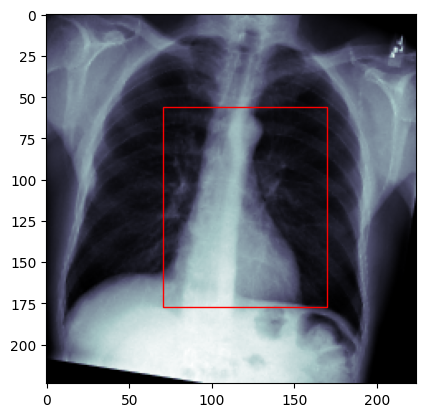

In [ ]:
img, bbox = dataset[0]

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.imshow(img[0], cmap='bone')
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], edgecolor='r', facecolor='none')
axes.add_patch(rect)
fig.tight_layout()

In [13]:
%%writefile dataset.py
from pathlib import Path
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

class CardiacDataset(Dataset):
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        super().__init__()
        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, index):
        patient = self.patients[index]
        data = self.labels[self.labels['name'] == patient]

        x_min = data['x0'].item()
        y_min = data['y0'].item()
        x_max = x_min + data['w'].item()
        y_max = y_min + data['h'].item()
        bbox = [x_min, y_min, x_max, y_max]

        file_path = self.root_path / patient
        img = np.load(f'{file_path}.npy').astype(np.float32)

        if self.augment:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)

            img, aug_bbox = self.augment(image=img, bounding_boxes = bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

        img = (img - 0.49430165816326493) / 0.2527964897943661
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)

        return img, bbox

Writing dataset.py


## Data Loading

In [14]:
import torch
from torch.utils.data import DataLoader
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import os
import imgaug.augmenters as iaa

from dataset import CardiacDataset

In [15]:
train_root_path = 'processed/heart-detection/train'
train_subjects = 'processed/heart-detection/train_subjects.npy'
val_root_path = 'processed/heart-detection/val'
val_subjects = 'processed/heart-detection/val_subjects.npy'

train_transforms = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(scale=(0.8, 1.2),
               rotate=(-10, 10),
               translate_px=(-10, 10))
])

In [16]:
train_dataset = CardiacDataset(path_to_labels_csv='data/rsna-pneumonia-detection-challenge/rsna_heart_detection.csv',
                               patients=train_subjects,
                               root_path=train_root_path,
                               augs=train_transforms)

val_dataset = CardiacDataset(path_to_labels_csv='data/rsna-pneumonia-detection-challenge/rsna_heart_detection.csv',
                             patients=val_subjects,
                             root_path=val_root_path,
                             augs=None)

In [17]:
batch_size = 8
num_workers = os.cpu_count() - 1

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True,
                              persistent_workers=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True,
                            persistent_workers=True)

## Model Creation

In [18]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model_weights = torchvision.models.ResNet18_Weights.DEFAULT
        self.model = torchvision.models.resnet18(weights=self.model_weights)
        self.model.conv1 = torch.nn.Conv2d(in_channels=1,
                                           out_channels=64,
                                           kernel_size=(7, 7),
                                           stride=(2, 2),
                                           padding=(3, 3),
                                           bias=False)
        self.model.fc = torch.nn.Linear(in_features=512,
                                        out_features=4,
                                        bias=True)

        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        self.validation_step_outputs = []

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()

        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        self.log(name='Train Loss', value=loss, prog_bar=True, logger=True)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()

        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        output_dict = {'prediction': pred,
                       'label': label}
        self.validation_step_outputs.append(output_dict)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Validation")

        return loss

    def on_validation_epoch_end(self):
        all_preds = []
        all_labels = []

        for output in self.validation_step_outputs:
            for pred in output['prediction'].detach().cpu():
                all_preds.append(pred)
            for label in output['label'].detach().cpu():
                all_labels.append(label)
        self.validation_step_outputs.clear()

        all_preds = torch.stack(all_preds)
        all_labels = torch.stack(all_labels)

        loss = self.loss_fn(all_preds, all_labels)
        self.log(name='Validation Loss', value=loss, prog_bar=True, logger=True)

    def log_images(self, x_ray, pred, label, name):
        results = []

        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]

            img = ((x_ray[i] * std) + mean).numpy()[0]

            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img=img, pt1=(x0, y0), pt2=(x1, y1), color=(0, 0, 0), thickness=2)

            x0, y0 = coords_pred[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img=img, pt1=(x0, y0), pt2=(x1, y1), color=(1, 1, 1), thickness=2)

            results.append(torch.tensor(img).unsqueeze(0))

        grid = torchvision.utils.make_grid(tensor=results, nrow=2)
        self.logger.experiment.add_image(name, grid, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [20]:
pl.seed_everything(42)

model = CardiacDetectionModel()

checkpoint_callback = ModelCheckpoint(monitor='Validation Loss',
                                      verbose=True,
                                      save_last=True,
                                      save_top_k=10,
                                      mode='min')

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [21]:
trainer = pl.Trainer(accelerator='auto',
                     devices='auto',
                     logger=TensorBoardLogger(save_dir='logs'),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/lightning_logs/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode
-------------------------------------------
0 | model   | ResNet  | 11.2 M | eval
1 | loss_fn | MSELoss | 0      | eval
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)
0         Modules in train mode
69        Modules in eval mode
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at logs/lightning_logs/version_0/checkpoints/last.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Evaluation

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

model = CardiacDetectionModel.load_from_checkpoint('logs/lightning_logs/version_0/checkpoints/last.ckpt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()
model.to(device);

In [24]:
preds = []
labels = []

with torch.inference_mode():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)

preds = torch.stack(preds)
labels = torch.stack(labels)

In [25]:
# This means an error of 3% from the actual points, which is good
abs(preds - labels).mean(0)

tensor([4.4673, 5.1193, 5.7991, 5.0328])

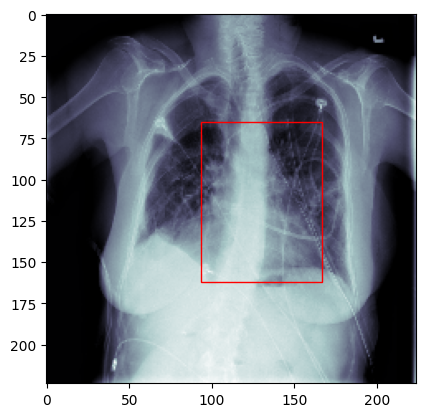

In [ ]:
IDX = 0
img, label = val_dataset[IDX]
pred = preds[IDX]

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.imshow(img[0], cmap='bone')
heart = patches.Rectangle((pred[0], pred[1]), pred[2] - pred[0], pred[3] - pred[1], edgecolor='r', facecolor='none')
axes.add_patch(heart)
fig.tight_layout()

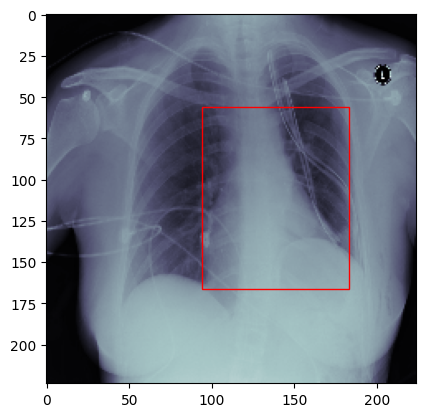

In [ ]:
IDX = 10
img, label = val_dataset[IDX]
pred = preds[IDX]

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.imshow(img[0], cmap='bone')
heart = patches.Rectangle((pred[0], pred[1]), pred[2] - pred[0], pred[3] - pred[1], edgecolor='r', facecolor='none')
axes.add_patch(heart)
fig.tight_layout()

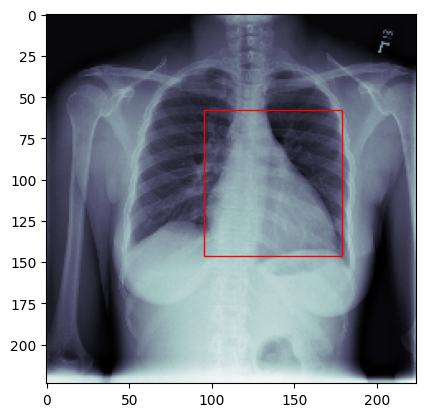

In [ ]:
IDX = 20
img, label = val_dataset[IDX]
pred = preds[IDX]

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.imshow(img[0], cmap='bone')
heart = patches.Rectangle((pred[0], pred[1]), pred[2] - pred[0], pred[3] - pred[1], edgecolor='r', facecolor='none')
axes.add_patch(heart)
fig.tight_layout()